In [2]:
import pylab 
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import glob
import os

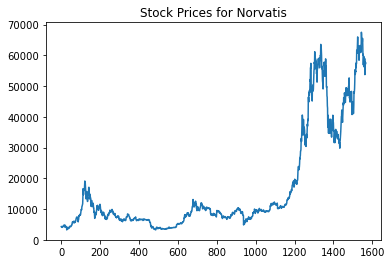

In [3]:
data = pd.read_csv("data/BTC.csv")
bitcoin_price=data['c'].values
#
plt.plot(bitcoin_price)
plt.title('Stock Prices for Norvatis')
plt.show()


In [4]:
def calculateReturn(prices):
    return (prices[1:]-prices[:-1])/prices[:-1]


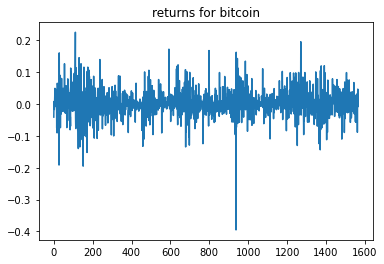

In [5]:
return_btc = calculateReturn(bitcoin_price)
plt.title('returns for bitcoin')
plt.plot(return_btc)
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(return_btc)
print(pvalue)

0.0


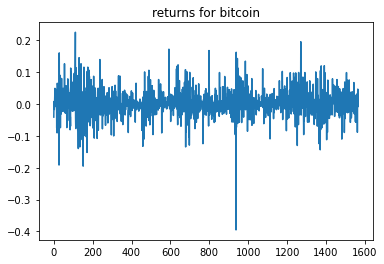

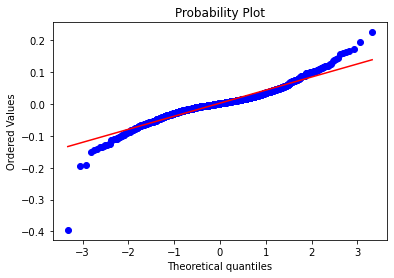

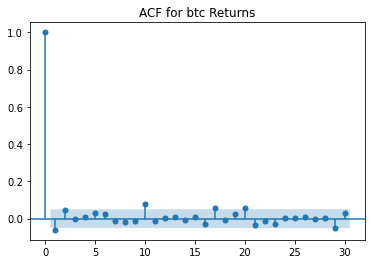

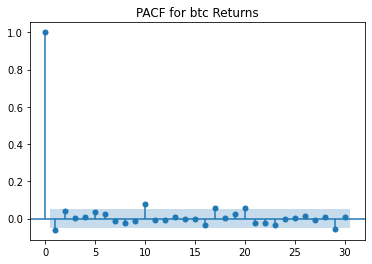

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plt.plot(return_btc)
plt.title('returns for bitcoin')
plt.show()
#
import scipy.stats as stats
stats.probplot(return_btc, dist="norm", plot=pylab)
pylab.show()

# Autocorrelation for Novartis returns
acf_plot = plot_acf(return_btc, lags=30, title='ACF for btc Returns')
# partial Autocorrelation for Novartis returns 
pacf_plot = plot_pacf(return_btc, lags=30, title='PACF for btc Returns')

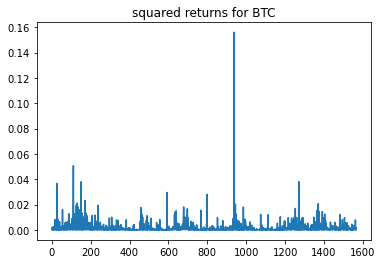

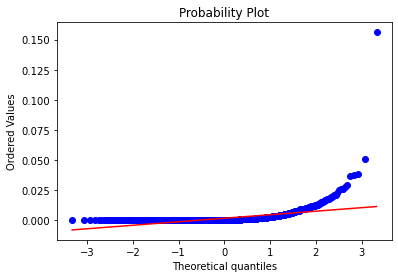

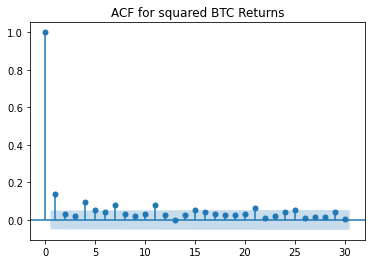

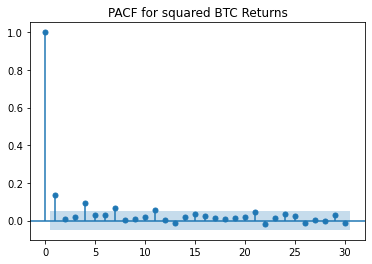

In [9]:
plt.plot(return_btc**2)
plt.title('squared returns for BTC')
plt.show()
#
stats.probplot(return_btc**2, dist="norm", plot=pylab)
pylab.show()

# Autocorrelation for Novartis squared returns
acf_plot = plot_acf(return_btc**2, lags=30, title='ACF for squared BTC Returns')
# partial Autocorrelation for Novartis squared returns 
pacf_plot = plot_pacf(return_btc**2, lags=30, title='PACF for squared BTC Returns')

In [11]:
# For NOVARTIS
#pip install arch
from arch import arch_model
am = arch_model(return_btc, vol='GARCH', p=1, q=1)
res=am.fit()
print(res.summary())


Iteration:      1,   Func. Count:      6,   Neg. LLF: 942031.4310338856
Iteration:      2,   Func. Count:     17,   Neg. LLF: 385968857865327.1
Iteration:      3,   Func. Count:     28,   Neg. LLF: 317775.13972487
Iteration:      4,   Func. Count:     38,   Neg. LLF: 1458661619990482.8
Iteration:      5,   Func. Count:     49,   Neg. LLF: 401727509658405.4
Iteration:      6,   Func. Count:     60,   Neg. LLF: 712659.3009310344
Iteration:      7,   Func. Count:     71,   Neg. LLF: 4523955898722893.0
Iteration:      8,   Func. Count:     81,   Neg. LLF: -2799.197269268735
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2799.1972657955375
            Iterations: 12
            Function evaluations: 81
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:

/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001801. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


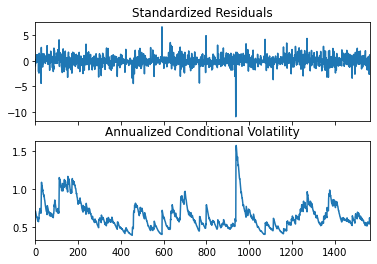

In [12]:
fig = res.plot(annualize="D")
#Annualized Volatility Formula = √252 * √Variance

/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


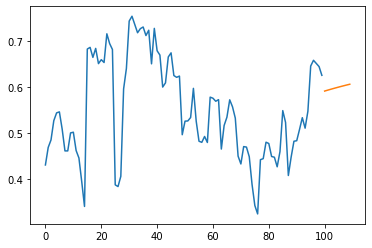

In [16]:

#https://github.com/chibui191/bitcoin_volatility_forecasting
#https://www.wallstreetmojo.com/volatility-formula/
yhat = res.forecast(horizon=10)
# plot forecast variance
#volatility

vol = yhat.variance.values[-1, :]


# calculate the annualized vol
vol_pred = vol**0.5 * np.sqrt(252)

# calculate a rolling volatility annualized
vol_ob = pd.Series(return_btc).rolling(window = 10).std() * np.sqrt(252)

a = np.arange(100)
b = np.arange(100, 110)
plt.plot(a,vol_ob[-100:])
plt.plot(b,vol_pred)
plt.show()

In [17]:
def predict_vol(file_name):
    
    data = pd.read_csv(file_name)
    price=data['c'].values
    return_price = calculateReturn(price)
    am = arch_model(return_price, vol='GARCH', p=1, q=1)
    res=am.fit()
    yhat = res.forecast(horizon=1) # we forcast only one vlaue in the futur (one day)
    vol_price = yhat.variance.values[-1, :]
    # calculate the annualized vol
    vol_pred = vol_price**0.5 * np.sqrt(252)
    today_vol = np.std(return_price) * np.sqrt(252)
    tomorrow_vol = vol_pred[0]

    print(today_vol)
    print(tomorrow_vol)
    result = 0
    if today_vol < tomorrow_vol:
        result = 1 - (today_vol / tomorrow_vol)


    return result
    
    

In [24]:
path = r'data/'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

result = {}
for file in all_files:
    
    resu = predict_vol(file)
    if resu != 0:
        name = file.split('/', 1 )
        name = name[1].split('.', 1 )[0]
        
        print('vol explode')
        result[name] = resu

/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01815. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWar

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1302053259.0341618
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13925541.31786177
Iteration:      3,   Func. Count:     21,   Neg. LLF: -15.811983659163857
Iteration:      4,   Func. Count:     26,   Neg. LLF: -15.83170793526827
Iteration:      5,   Func. Count:     31,   Neg. LLF: -14.836795535588168
Iteration:      6,   Func. Count:     37,   Neg. LLF: -15.832618067355748
Iteration:      7,   Func. Count:     42,   Neg. LLF: -15.832637486072123
Iteration:      8,   Func. Count:     46,   Neg. LLF: -15.832637486134232
Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.832637486072123
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 8
2.1385539581096404
2.096992119790719
Iteration:      1,   Func. Count:      6,   Neg. LLF: 230136308.4873238
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4802972.056186156
Iteration:      3,   F

/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02133. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWar

2.482177549522701
0.8852995485179449
Iteration:      1,   Func. Count:      6,   Neg. LLF: 605613.835437146
Iteration:      2,   Func. Count:     16,   Neg. LLF: 10445.513744998145
Iteration:      3,   Func. Count:     23,   Neg. LLF: -193.05027545692732
Iteration:      4,   Func. Count:     30,   Neg. LLF: -30.44894611342429
Iteration:      5,   Func. Count:     37,   Neg. LLF: -200.34605100600083
Iteration:      6,   Func. Count:     44,   Neg. LLF: -209.4691614535136
Iteration:      7,   Func. Count:     50,   Neg. LLF: -209.47372464626204
Iteration:      8,   Func. Count:     54,   Neg. LLF: -209.47372464625826
Optimization terminated successfully    (Exit mode 0)
            Current function value: -209.47372464626204
            Iterations: 8
            Function evaluations: 54
            Gradient evaluations: 8
1.7768527237030594
1.4923186904810086
Iteration:      1,   Func. Count:      6,   Neg. LLF: 139311.60232853732
Iteration:      2,   Func. Count:     16,   Neg. LLF: 104

/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03714. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWar

Iteration:      7,   Func. Count:     52,   Neg. LLF: -565.3332087240781
Iteration:      8,   Func. Count:     57,   Neg. LLF: -565.3345381382805
Iteration:      9,   Func. Count:     62,   Neg. LLF: -565.3345684564149
Iteration:     10,   Func. Count:     66,   Neg. LLF: -565.3345684562842
Optimization terminated successfully    (Exit mode 0)
            Current function value: -565.3345684564149
            Iterations: 10
            Function evaluations: 66
            Gradient evaluations: 10
1.270582274165984
0.963396186291717
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3358944.8431384047
Iteration:      2,   Func. Count:     16,   Neg. LLF: -185.35067603996538
Iteration:      3,   Func. Count:     23,   Neg. LLF: -212.43029495159118
Optimization terminated successfully    (Exit mode 0)
            Current function value: -212.4302973868541
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 3
1.433111302019446
1.0028909504475

/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00815. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWar

Iteration:      5,   Func. Count:     36,   Neg. LLF: 11.1082344652427
Iteration:      6,   Func. Count:     42,   Neg. LLF: -216.8460343899845
Iteration:      7,   Func. Count:     48,   Neg. LLF: -218.01709024744454
Iteration:      8,   Func. Count:     54,   Neg. LLF: -220.8033435807445
Iteration:      9,   Func. Count:     60,   Neg. LLF: 101745197.04416159
Iteration:     10,   Func. Count:     66,   Neg. LLF: -224.14157040850313
Iteration:     11,   Func. Count:     71,   Neg. LLF: -224.1434579305889
Iteration:     12,   Func. Count:     76,   Neg. LLF: -224.1435530637922
Iteration:     13,   Func. Count:     81,   Neg. LLF: -224.14355364985013
Optimization terminated successfully    (Exit mode 0)
            Current function value: -224.14355364985013
            Iterations: 13
            Function evaluations: 81
            Gradient evaluations: 13
0.4837641353703815
0.2998960581476831
Iteration:      1,   Func. Count:      6,   Neg. LLF: 55317865187.00105
Iteration:      2,   

/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.009962. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWa

Iteration:     10,   Func. Count:     63,   Neg. LLF: -163.9277335339107
Iteration:     11,   Func. Count:     67,   Neg. LLF: -163.92773353404272
Optimization terminated successfully    (Exit mode 0)
            Current function value: -163.9277335339107
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11
1.9018637016391322
1.8497157969844236
Iteration:      1,   Func. Count:      5,   Neg. LLF: -4847.687048134429
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4847.687046400157
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
0.01343592087986895
0.0051035787952878695
Iteration:      1,   Func. Count:      6,   Neg. LLF: 25122238.67314473
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1816.5961507619688
Iteration:      3,   Func. Count:     24,   Neg. LLF: -899.1573434028778
Iteration:      4,   Func. Count:     31,   Neg. LLF: -21.96256222

/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008355. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning ca

Iteration:      2,   Func. Count:     17,   Neg. LLF: 2146.999206925185
Iteration:      3,   Func. Count:     27,   Neg. LLF: 6141.698730995378
Iteration:      4,   Func. Count:     37,   Neg. LLF: -923.3863411538096
Iteration:      5,   Func. Count:     43,   Neg. LLF: -945.154717939231
Iteration:      6,   Func. Count:     49,   Neg. LLF: -760.9633126317906
Iteration:      7,   Func. Count:     57,   Neg. LLF: -945.9005480781449
Iteration:      8,   Func. Count:     63,   Neg. LLF: -946.0996148777085
Iteration:      9,   Func. Count:     68,   Neg. LLF: -946.1003664564679
Iteration:     10,   Func. Count:     72,   Neg. LLF: -946.1003664606858
Optimization terminated successfully    (Exit mode 0)
            Current function value: -946.1003664564679
            Iterations: 10
            Function evaluations: 72
            Gradient evaluations: 10
1.3339944248904514
1.6056582245248499
vol explode
Iteration:      1,   Func. Count:      6,   Neg. LLF: 28685257.667866483
Iteration:   

/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003847. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWa

Iteration:      5,   Func. Count:     45,   Neg. LLF: 2482674.646523432
Iteration:      6,   Func. Count:     51,   Neg. LLF: 409003.44305315084
Iteration:      7,   Func. Count:     62,   Neg. LLF: 89068.11995234266
Iteration:      8,   Func. Count:     73,   Neg. LLF: 3120.4487001365824
Iteration:      9,   Func. Count:     82,   Neg. LLF: -944.0642622370804
Iteration:     10,   Func. Count:     89,   Neg. LLF: -1789.10954093592
Iteration:     11,   Func. Count:     95,   Neg. LLF: -1868.6543996132582
Iteration:     12,   Func. Count:    101,   Neg. LLF: -1960.0343303014954
Iteration:     13,   Func. Count:    107,   Neg. LLF: -1965.5823778622107
Iteration:     14,   Func. Count:    112,   Neg. LLF: -1965.599095945501
Iteration:     15,   Func. Count:    118,   Neg. LLF: -1965.6973437576726
Iteration:     16,   Func. Count:    123,   Neg. LLF: -1965.697413294
Iteration:     17,   Func. Count:    127,   Neg. LLF: -1965.6974134496452
Optimization terminated successfully    (Exit mode 0

/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008356. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -537.8541637546714
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -537.8541637601718
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
0.00502945861422409
0.004835207436817421
Iteration:      1,   Func. Count:      6,   Neg. LLF: 837743.7107482089
Iteration:      2,   Func. Count:     16,   Neg. LLF: 265513.7385762115
Iteration:      3,   Func. Count:     23,   Neg. LLF: -369.95689515462607
Iteration:      4,   Func. Count:     29,   Neg. LLF: -186.76102163208296
Iteration:      5,   Func. Count:     36,   Neg. LLF: -374.6649397694112
Iteration:      6,   Func. Count:     42,   Neg. LLF: -361.61685102308957
Iteration:      7,   Func. Count:     48,   Neg. LLF: -385.70694604167545
Iteration:      8,   Func. Count:     54,   Neg. LLF: -394.96544976254785
Iteration:      9,   Func. Count:     59,   Neg. LLF: -394.96558287504206
Iteration:     10, 

/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.009311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 28078019.77426766
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1304.4635590172475
Iteration:      3,   Func. Count:     24,   Neg. LLF: -1898.610377478129
Iteration:      4,   Func. Count:     30,   Neg. LLF: -1781.7865324272466
Iteration:      5,   Func. Count:     36,   Neg. LLF: 181882485.40124702
Iteration:      6,   Func. Count:     47,   Neg. LLF: 5829.484519090547
Iteration:      7,   Func. Count:     55,   Neg. LLF: -1536.5611523172352
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1880.3936262924353
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1798.0332097516136
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1888.0298209771793
Iteration:     11,   Func. Count:     84,   Neg. LLF: -1914.1451394367466
Iteration:     12,   Func. Count:     89,   Neg. LLF: -1914.1451392072122
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1914.1451397424876
        

/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003755. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2837894.854847194
Iteration:      2,   Func. Count:     17,   Neg. LLF: 153.2103187199536
Iteration:      3,   Func. Count:     26,   Neg. LLF: -861.2177369327919
Iteration:      4,   Func. Count:     33,   Neg. LLF: -1076.9998576097391
Iteration:      5,   Func. Count:     39,   Neg. LLF: -1060.1049313101898
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1080.7394235266536
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1075.467404557086
Iteration:      8,   Func. Count:     57,   Neg. LLF: -1084.6558731663056
Iteration:      9,   Func. Count:     63,   Neg. LLF: -1084.7584964086366
Iteration:     10,   Func. Count:     68,   Neg. LLF: -1084.7586970293783
Iteration:     11,   Func. Count:     73,   Neg. LLF: -1084.7586977421229
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1084.7586977421229
            Iterations: 11
            Function evaluations: 73
            Gradie

/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.1e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/remy/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/home/remy/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message.

In [25]:
result

{'XTZ': 0.12675937022031547,
 'ENS': 1.1667693218475605e-05,
 'MBOX': 0.3766960602227434,
 'ENJ': 0.040190863989346015,
 'ZEC': 0.2766486322764007,
 'STX': 0.008241771437104806,
 'ANKR': 0.16919154741961973,
 'RSR': 0.11553160765672088,
 'BAT': 0.4887965637399446,
 'OCEAN': 0.05916433257287024,
 'ROSE': 0.05500714157639541}